In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Import dependencies and Load data

In [2]:
import spacy
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
print('length of data:',len(train))
train.isnull().sum()

length of data: 7613


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

For simplicity, we will just be focusing on text and target column. We will drop the id, keyword and location columns.

In [6]:
train=train.drop(['id','keyword','location'],axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Data Preprocessing

We will create a few functions for doing some text preprocessing:
* Lowercase all the text
* Replace some abbreviations
* Remove stopwords (words such as 'and', 'the','is')
* Lemmatization (convert words to base form)
* Remove HTML tags
* Remove URL
* Remove special characters

In [7]:
#Text lowercasing
def lowercase(text):
    return text.lower()

replacements = {
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "i'll": "i will",
    "you'll": "you will",
    "we'll": "we will",
    "they'll": "they will",
    "he'd": "he would",
    "she'd": "she would",
    "it'd": "it would",
    "i'd": "i would",
    "you'd": "you would",
    "we'd": "we would",
    "they'd": "they would",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "can't": "cannot",
    "won't": "will not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "mightn't": "might not",
    "mustn't": "must not",
    "aren't": "are not",
    "isn't": "is not",
    "wasn't": "was not",
    "weren't": "were not",
    # Add more replacements as needed
}

#Abberivation replacement
def replace_abb(text):
    # Define a dictionary of replacements for short form pronouns and contraction
    
    # Iterate through the replacements and apply them to the text
    for short_form, full_form in replacements.items():
        text = text.replace(short_form, full_form)
    
    return text


#Stopword removal and lemmatization
nlp = spacy.load("en_core_web_sm")

def remove_stopwords(text):
    doc = nlp(text)
    filtered_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return filtered_text


#HTML tag removal
def remove_html_tags(input_text):
    soup = BeautifulSoup(input_text, 'html.parser')
    text_without_tags = soup.get_text()
    return text_without_tags


#URL data removal
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Special Character removal
def remove_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[=!#%@$^&*()_+{}\[\]:;"\'<>,.?/|\\\-]|[0-9]'
    
    # Use the sub() function to replace matches with an empty string
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [8]:
train['filtered_text']=train['text'].apply(lowercase)
train['filtered_text'] = train['filtered_text'].apply(replace_abb)
train['filtered_text'] = train['filtered_text'].apply(remove_stopwords)
train['filtered_text'] = train['filtered_text'].apply(remove_html_tags)
train['filtered_text'] = train['filtered_text'].apply(remove_url)
train['filtered_text'] = train['filtered_text'].apply(remove_special_characters)

/tmp/ipykernel_33/942621130.py:68: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(input_text, 'html.parser')


In [9]:
train.head()

,text,target,filtered_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...


# Wordcloud

In [10]:
combined_text_pos = ' '.join(train[train['target']==1]['filtered_text'])
combined_text_neg = ' '.join(train[train['target']==0]['filtered_text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(combined_text_pos)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(combined_text_neg)

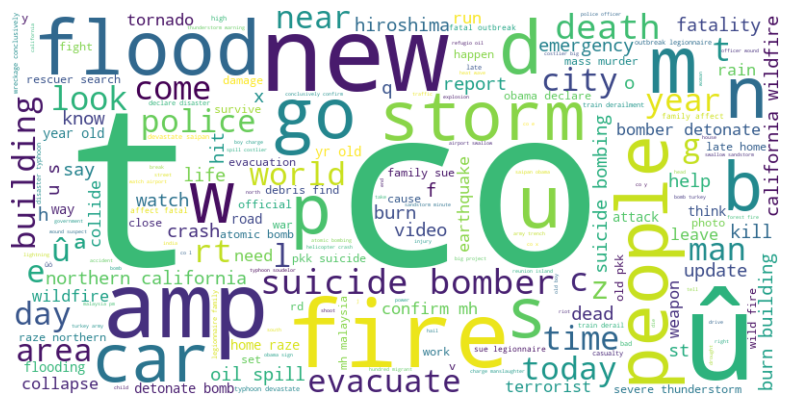

In [11]:
#Actual disaster wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

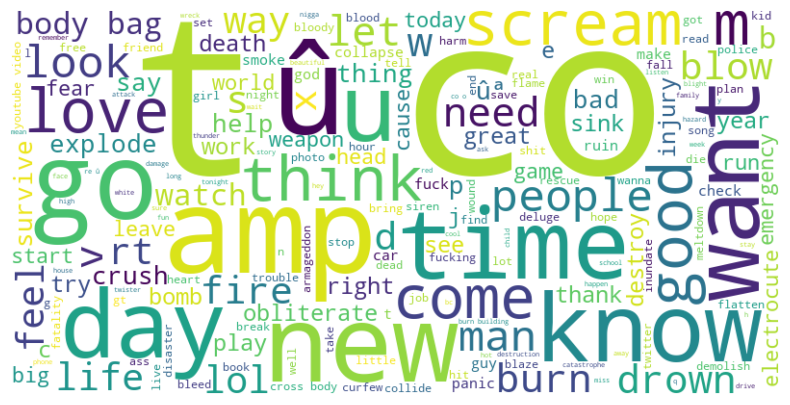

In [12]:
#False disaster wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

We can see that there are a few common words that keep appearing in both wordcloud. We will remove the following:
* Common words: co, time, new, think, amp
* Individual letters a-z
* u with circumflex

In [13]:
#Remove common words
import re

def remove_special_characters(text):
    words_to_remove = ['co', 'time', 'new', 'think', 'amp']
    letters_to_remove = r'\b[a-z]\b'  # Matches individual letters from 'a' to 'z' as whole words
    u_circumflex = '\u00FB'  # u with circumflex
    
    # Remove specific words
    for word in words_to_remove:
        text = text.replace(word, '')

    # Remove individual letters from 'a' to 'z' if they are standalone words
    text = re.sub(letters_to_remove, '', text, flags=re.IGNORECASE)
    
    # Remove u with circumflex
    text = text.replace(u_circumflex, '')

    return text

train['filtered_text'] = train['filtered_text'].apply(remove_special_characters)

In [14]:
train.head()

,text,target,filtered_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...


In [15]:
combined_text_pos_2 = ' '.join(train[train['target']==1]['filtered_text'])
wordcloud_pos_2 = WordCloud(width=800, height=400, background_color='white').generate(combined_text_pos_2)

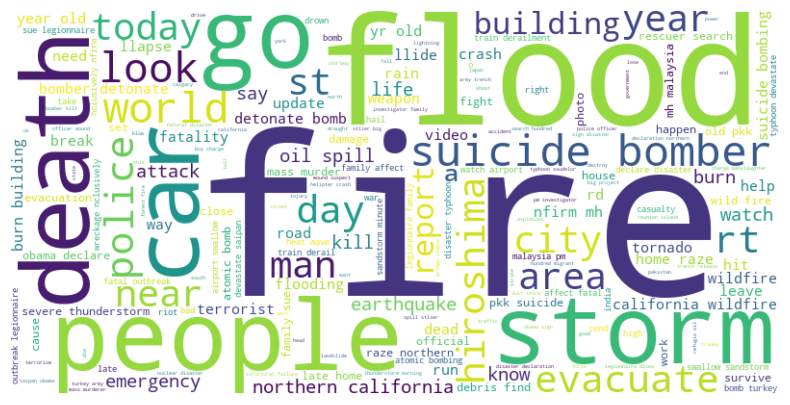

In [16]:
#Actual disaster wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos_2, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

The wordcloud looks a lot cleaner now.

# Model training

**1** **Feature engineering with DTM:**
* Logistic Regression
* Random forest

**2** **Feature engineering with word2vec:**
* Apply RNN/LSTM

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
#Straified data split, to ensure the imbalanced dataset is split into both training and test set.
xtrain,xtest,ytrain,ytest=train_test_split(train['filtered_text'], train['target'], stratify=train['target'], test_size=0.3, random_state=42)

# 1. DTM

The document term matrix counts the number of times a word appears in the document, and expresses it as matrix form.

In [19]:
#Create Document Term Matrix
vectorizer = CountVectorizer()
xtrain = vectorizer.fit_transform(xtrain)
xtest = vectorizer.transform(xtest)

In [20]:
#Prediction using logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(xtrain, ytrain)

# Predict sentiment on the test set
predictions_lr = logreg.predict(xtest)

# Calculate evaluation metrics
print("Accuracy of Logistic Regression:", accuracy_score(ytest, predictions_lr))

Accuracy of Logistic Regression: 0.7955341506129597


In [21]:
#Prediction using random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42).fit(xtrain, ytrain)

# Predict sentiment on the test set
predictions_rf = rf.predict(xtest)

# Calculate evaluation metrics
print("Accuracy of Random Forest Classifier:", accuracy_score(ytest, predictions_rf))

Accuracy of Random Forest Classifier: 0.7950963222416813


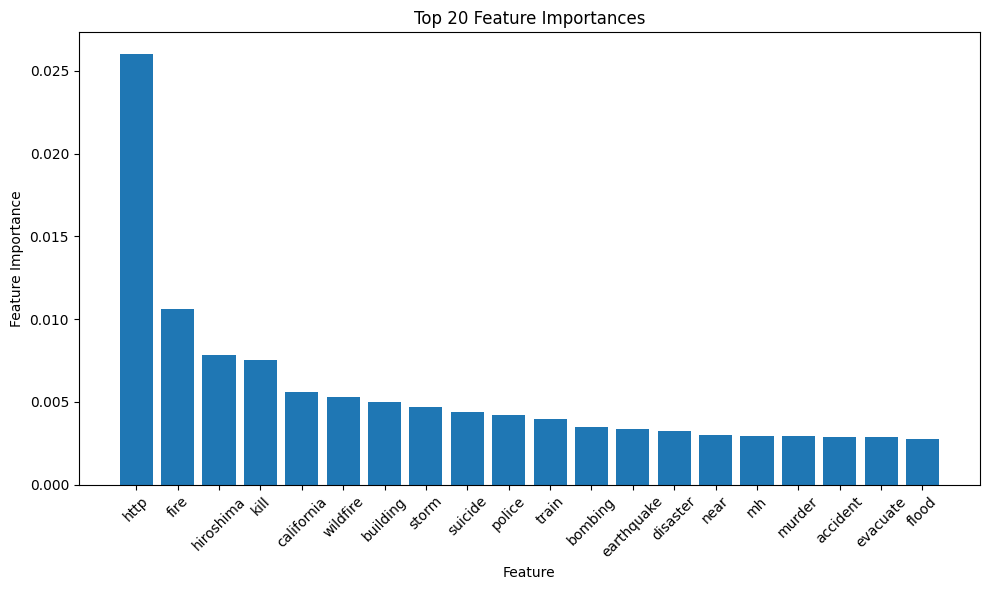

In [22]:
#Feature Importance of random forest

feature_importances = rf.feature_importances_

# Get feature names
feature_names = vectorizer.get_feature_names_out()

indices = np.argsort(feature_importances)[::-1]

# Get feature names (assuming X is a pandas DataFrame or a NumPy array with feature names)

# Plot the top 20 features in descending order
top_features_count = 20
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(top_features_count), feature_importances[indices[:top_features_count]], align="center")
plt.xticks(range(top_features_count), [feature_names[i] for i in indices[:top_features_count]], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.tight_layout()
plt.show()

# 2. Word2vec

Word2Vec turns words into vectors, which will then be used to train our RNN/LSTM model.

In [23]:
# For word2vec
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [24]:
# Tokenize and apply word2vec model
train['filtered_text_token'] = train['filtered_text'].apply(word_tokenize)
w2v_model = Word2Vec(sentences=train['filtered_text_token'], vector_size=50, window=1, min_count=5, sg=0, seed=42) #CBOW variation

In [25]:
train.head()

,text,target,filtered_text,filtered_text_token
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[deed, reason, earthquake, allah, forgive]"
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer ...,"[resident, ask, shelter, place, notify, office..."
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation or...,"[people, receive, wildfire, evacuation, order,..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire ...,"[got, send, photo, ruby, alaska, smoke, wildfi..."


In [26]:
# Determine our max length pad sequence
print('max length of filtered text:',max(train['filtered_text_token'].apply(len)))

max length of filtered text: 21


In [27]:
xtrain,xtest,ytrain,ytest=train_test_split(train['filtered_text'], train['target'], stratify=train['target'], test_size=0.3, random_state=42)

In [28]:
# Convert words to indices using the Word2Vec model vocabulary
word_vectors = w2v_model.wv
tokenizer = Tokenizer()
tokenizer.word_index = {word: idx for idx, word in enumerate(word_vectors.index_to_key)}

# Convert text to sequences of word indices
sequences_train = tokenizer.texts_to_sequences(xtrain)
sequences_test = tokenizer.texts_to_sequences(xtest)

# Pad sequences for consistent input shape
max_sequence_length = 21  # Adjust this based on your dataset and sequence lengths
xtrain = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
xtest = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

# Create an embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, w2v_model.vector_size))
for word, idx in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[idx] = word_vectors[word]

# Build LSTM model with Word2Vec embeddings
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=w2v_model.vector_size,
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(LSTM(units=128, dropout=0.2,return_sequences=True))
model.add(LSTM(units=128, dropout=0.2))
#model.add(Dense(units=1, activation='sigmoid'))  # For binary classification; use softmax for multi-class
#model.add(Dense(units=2, activation='softmax')) 
model.add(Dense(units=1, activation='sigmoid')) 
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model
history = model.fit(xtrain, ytrain, epochs=20, batch_size=16, validation_data=(xtest, ytest))

# Evaluate the model
loss, accuracy = model.evaluate(xtest, ytest)
print(f'Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
334/334 [==============================] - 8s 9ms/step - loss: 0.6825 - accuracy: 0.5714 - val_loss: 0.6857 - val_accuracy: 0.5705
Epoch 2/20
334/334 [==============================] - 3s 8ms/step - loss: 0.6843 - accuracy: 0.5658 - val_loss: 0.6831 - val_accuracy: 0.5950
Epoch 3/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6761 - accuracy: 0.5740 - val_loss: 0.6723 - val_accuracy: 0.5933
Epoch 4/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6610 - accuracy: 0.5902 - val_loss: 0.6602 - val_accuracy: 0.5933
Epoch 5/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6548 - accuracy: 0.6084 - val_loss: 0.6558 - val_accuracy: 0.6125
Epoch 6/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6531 - accuracy: 0.6116 - val_loss: 0.6458 - val_accuracy: 0.6217
Epoch 7/20
334/334 [==============================] - 2s 7ms/step - loss: 0.6463 - accuracy: 0.6194 - val_loss: 0.6476 - val_accuracy: 0.6213
Epoch 

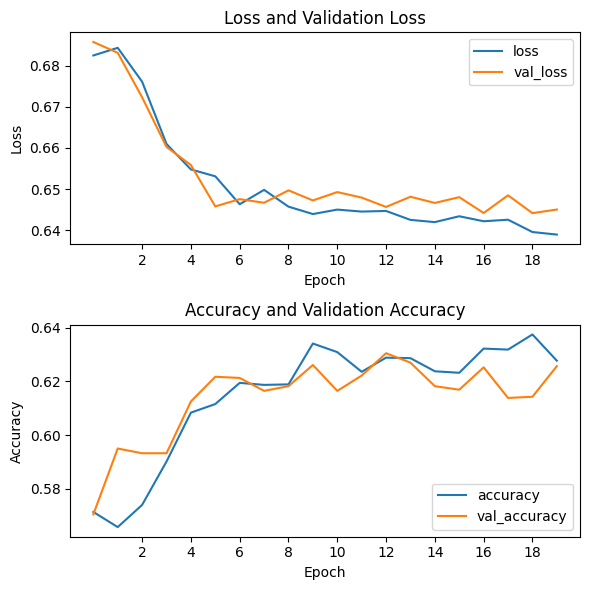

In [29]:
# Plot out accuracy and loss curve

history_df = pd.DataFrame(history.history)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

x_ticks = np.arange(2, len(history_df) + 1, 2)
axes[0].set_xticks(x_ticks)
axes[0].set_xticklabels(x_ticks)


# Plot loss and val_loss 
history_df.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_title('Loss and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

x_ticks = np.arange(2, len(history_df) + 1, 2)
axes[1].set_xticks(x_ticks)
axes[1].set_xticklabels(x_ticks)

# Plot accuracy and val_accuracy 
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
axes[1].set_title('Accuracy and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

LSTM seems to be underperforming here. We would likely need more data to perform better.

# Test data preprocessing

In [30]:
test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [31]:
Id=test['id']
test=test.drop(['id','keyword','location'],axis=1)

In [32]:
test['filtered_text'] = test['text'].apply(lowercase)
test['filtered_text'] = test['filtered_text'].apply(replace_abb)
test['filtered_text'] = test['filtered_text'].apply(remove_stopwords)
test['filtered_text'] = test['filtered_text'].apply(remove_html_tags)
test['filtered_text'] = test['filtered_text'].apply(remove_url)
test['filtered_text'] = test['filtered_text'].apply(remove_special_characters)
test['filtered_text'] = test['filtered_text'].apply(remove_special_characters)

test = vectorizer.transform(test['filtered_text'])


/tmp/ipykernel_33/942621130.py:68: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(input_text, 'html.parser')


# Final Submission with logistic regression

In [33]:
#Final submission with logistic regression

ypred=logreg.predict(test)
final = np.round(ypred)
output = pd.DataFrame({'id': Id,'target': final.astype(int) })
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [34]:
output.to_csv('submission.csv', index=False)